In [1]:
# instalar as bibliotecas necessárias
#!pip install numpy pandas matplotlib scikit-learn tabletext scipy seaborn plotly

## Determinar a quantidade de Cluster para o algorítmo K-means

In [2]:
# importar bibliotecas
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

import scipy.stats

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from IPython.display import display,HTML
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

In [3]:
#configurar tema dos gráficos
sns.set_theme()

In [4]:
def avaliar_opcoes_arranjo(qtd_min_clusters,qtd_max_clusters,dataset):
    # Definir range de clusters
    range_clusters = range(qtd_min_clusters,qtd_max_clusters+1)
    
    # Lista para armazenar os resultados da clusterização para cada arranjo
    resultados=[]
    
    for i,k in enumerate(range_clusters):
        resultado={"arranjo":f"{k} Grupos","qtd_grupos":k }
        
        #print("="*24)
        #print(f"Calculando K-Means para {k } clusters")
        #print("_"*24)
        # Criar um objeto KMeans
        kmeans = KMeans(n_clusters=k)
        
        # Treinar o modelo
        kmeans.fit(dataset)
        # Obter os rótulos dos clusters para cada ponto de dados
        rotulos = kmeans.labels_
        centroides = kmeans.cluster_centers_
        
        resumo_classificacao=[]
        qtd_por_grupos=pd.DataFrame(rotulos).groupby(0)[0].count()
        
        for i,qtd in enumerate(qtd_por_grupos):
            resumo_classificacao.append({"grupo":i+1,"qtd":qtd,"silhueta":0})
    
        # Calcular a silhueta para cada amostra
        silhuetas = silhouette_samples(dados, rotulos)
        
        # Calcular a média da silhueta
        silhueta_media = silhouette_score(dados, rotulos)
        resultado["silhueta_media"]=silhueta_media
    
        
        # Calcular a média da silhueta para cada grupo
        for i in np.unique(rotulos):
            resumo_classificacao[i]["silhueta"]=np.mean(silhuetas[rotulos == i])
            resumo_classificacao[i]["centroides"]=centroides[i]
    
        resultado["resumo_classificacao"]=resumo_classificacao
        resultado["rotulos"]=rotulos
        resultado["silhuetas"]=silhuetas
        resultado["centroides"]=centroides
        #print(resultado)
        
        resultados.append(resultado)
    return resultados

In [5]:
def obter_resultados_validos(resultados,silhueta_corte=0.50):
    # Avaliar resultados de clusterização para cada arranjo
    resultados_validos=[]
    for res in resultados:
        if res["silhueta_media"] >silhueta_corte:
            res["e_valido"]=True
            for grupo in res["resumo_classificacao"]:
                if grupo["silhueta"]<silhueta_corte: # largura da silhueta do grupo
                    res["e_valido"]=False
                    pass
            
            resultados_validos.append(res)
    
    return resultados_validos

In [6]:
def calcular_entropia_1(valores_variavel):
    soma_valores = np.sum(valores_variavel)
    qtd_valores=len(valores_variavel)
    ln = np.log(qtd_valores)
    entropia = (-1/ln)*soma_valores
    #print(soma_valores,qtd_valores,ln,entropia,1-entropia)
    return 1-entropia

In [7]:
def calcular_entropia(valores_variavel):
    unique_values, value_counts = np.unique(valores_variavel, return_counts=True)
    value_probs = value_counts / len(valores_variavel)
    entropy = -np.sum(value_probs * np.log2(value_probs + 1e-10))  # Adicionando um pequeno valor para evitar log(0)
    return entropy

In [8]:
def selecionar_melhor_opcao_arranjo(resultados_validos):
    if len(resultados_validos)==0:
        return None
        
    arranjo_selecionado=None
    todos_arranjos_validos=False
    
    menor_grupo = resultados_validos[0]["qtd_grupos"]
    maior_silhueta=resultados_validos[0]["silhueta_media"]
    
    indice_menor_grupo=0
    indice_maior_silhueta=0
    
    for i,res in enumerate(resultados_validos):
        if menor_grupo > res["qtd_grupos"]:
            menor_grupo=res["qtd_grupos"]
            indice_menor_grupo=i
            print(menor_grupo ,res["qtd_grupos"])
            
        if maior_silhueta < res["silhueta_media"]:
            maior_silhueta=res["silhueta_media"]
            indice_maior_silhueta=i
            print(maior_silhueta ,res["silhueta_media"])
    
    if todos_arranjos_validos:
        arranjo_selecionado= resultados_validos[indice_menor_grupo]
    else:
        arranjo_selecionado= resultados_validos[indice_maior_silhueta]
    
    return arranjo_selecionado

In [9]:
def imprimir_dados_arranjo(arranjo):
   
    display(HTML(
    f'''
    <h4> Detalhes do Arranjo</h4>
    <hr>
    <ul>
        <li><b>Arranjo selecionado</b>: {arranjo["arranjo"]}</li>
        <li><b>Qtd. Grupos</b>: {arranjo["qtd_grupos"]}</li>
        <li><b>Silhueta média</b>: {arranjo["silhueta_media"]:.4f}</li>
    </ul>
    <br/>
    <table>
        <tr><th>No.</th><th>Qtd. Registros</th><th>Silhueta</th></tr>
        {   
            '</tr><tr>'.join(
            '<td>{}</td><td>{}</td><td>{}</td>'.format(grupo["grupo"],grupo["qtd"],grupo["silhueta"])
            for grupo in arranjo["resumo_classificacao"])
                
        }
    </table>
    '''
))

In [10]:
def imprimir_grafico_analise_arranjo(arranjo):
    cluster =arranjo
    
    print(
        "For n_clusters =",
        cluster["qtd_grupos"],
        "The average silhouette_score is :",
        cluster["silhueta_media"],
    )
    
    # Criar um gráfico com 1 linha e 2 colunas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Gráfico para exibir a silhueta
    # Definir os limites
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(dfArquivo) + (cluster["qtd_grupos"] + 1) * 10])
    
    y_lower = 10
    
    for i in range(cluster["qtd_grupos"]):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = cluster["silhuetas"][cluster["rotulos"] == i]
    
        ith_cluster_silhouette_values.sort()
    
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
    
        color = cm.nipy_spectral(float(i) / cluster["qtd_grupos"])
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )
    
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=cluster["silhueta_media"], color="red", linestyle="--")
    
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    
    
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster["rotulos"].astype(float) / cluster["qtd_grupos"])
    ax2.scatter(
        dfArquivo.iloc[:, 1], dfArquivo.iloc[:, 2], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )
    
    # Labeling the clusters
    centers = cluster["centroides"]
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )
    
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
    
    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        %cluster["qtd_grupos"],
        fontsize=14,
        fontweight="bold",
    )
    
    plt.show()

In [65]:
# abrir dataset com os indicadores
PATH_TO_DATASET="../dataset/in/dados_k_means.csv"
dfArquivo=pd.read_csv(PATH_TO_DATASET,sep=";")

# Excluir coluna do identificador censitário
dados=dfArquivo.drop(["estado"],axis=1)

dfArquivo.describe()

,custo_terreno,vacas_ordenhadas,mil_litros_leite,profissionais,consumo,logistica,manutencao,busca_laticinios,fabrica_mais_50_empregados
count,27.000000,2.700000e+01,2.700000e+01,27.000000,2.700000e+01,27.000000,27.000000,27.000000,27.000000
mean,0.849529,5.886275e+05,2.406743e+05,6125.037037,2.222240e+08,15.227418,13.882991,30.666667,14.851852
std,0.098807,6.767468e+05,3.992615e+05,10248.450631,4.079214e+08,3.184683,7.465999,22.976577,22.294711
min,0.591183,5.170000e+03,0.000000e+00,141.000000,1.979360e+04,11.390342,0.000000,0.000000,0.000000
25%,0.793574,1.562565e+05,1.669850e+04,842.500000,8.496190e+06,13.287405,6.483875,15.000000,4.000000
50%,0.873004,3.410680e+05,6.633500e+04,1973.000000,8.294908e+07,14.528777,15.952174,25.000000,8.000000
75%,0.924758,8.179220e+05,1.674015e+05,5264.000000,1.986161e+08,16.501899,19.026273,37.000000,12.500000
max,0.979490,3.161477e+06,1.644351e+06,43876.000000,1.927988e+09,23.882534,27.444527,100.000000,102.000000


In [76]:

for col in dados.columns:
    dados[col]=dados[col]/dados[col].abs().max()

dados.describe()

,vacas_ordenhadas,mil_litros_leite,profissionais,consumo,logistica,manutencao,busca_laticinios,fabrica_mais_50_empregados
count,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
mean,0.186188,0.146364,0.139599,0.115262,0.637596,0.505856,0.306667,0.145606
std,0.214060,0.242808,0.233578,0.211579,0.133348,0.272040,0.229766,0.218576
min,0.001635,0.000000,0.003214,0.000010,0.476932,0.000000,0.000000,0.000000
25%,0.049425,0.010155,0.019202,0.004407,0.556365,0.236254,0.150000,0.039216
50%,0.107882,0.040341,0.044968,0.043024,0.608343,0.581252,0.250000,0.078431
75%,0.258715,0.101804,0.119974,0.103017,0.690961,0.693263,0.370000,0.122549
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Avaliar classificação com as sugestões de quantidade ótima de grupos sugerida pelos métodos de avaliação

For n_clusters = 2 The average silhouette_score is : 0.513315723756042


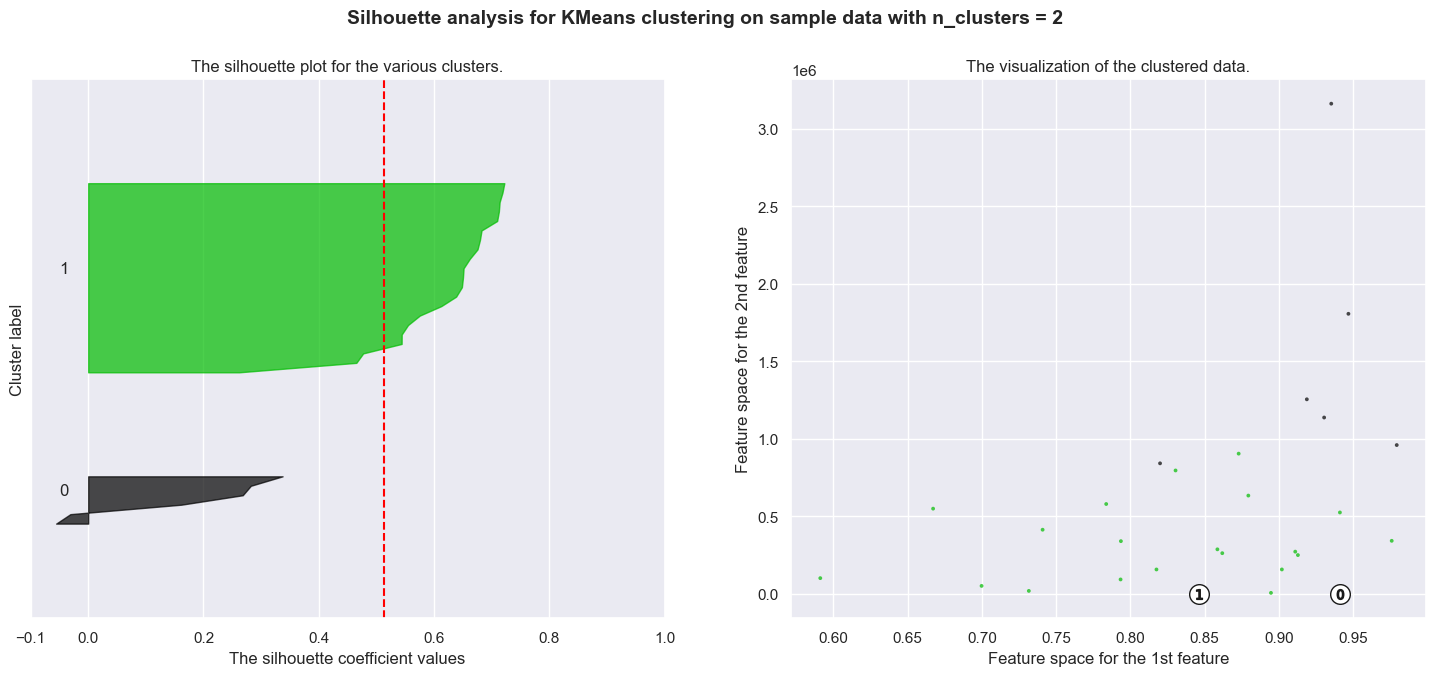

For n_clusters = 8 The average silhouette_score is : 0.26172612836869297


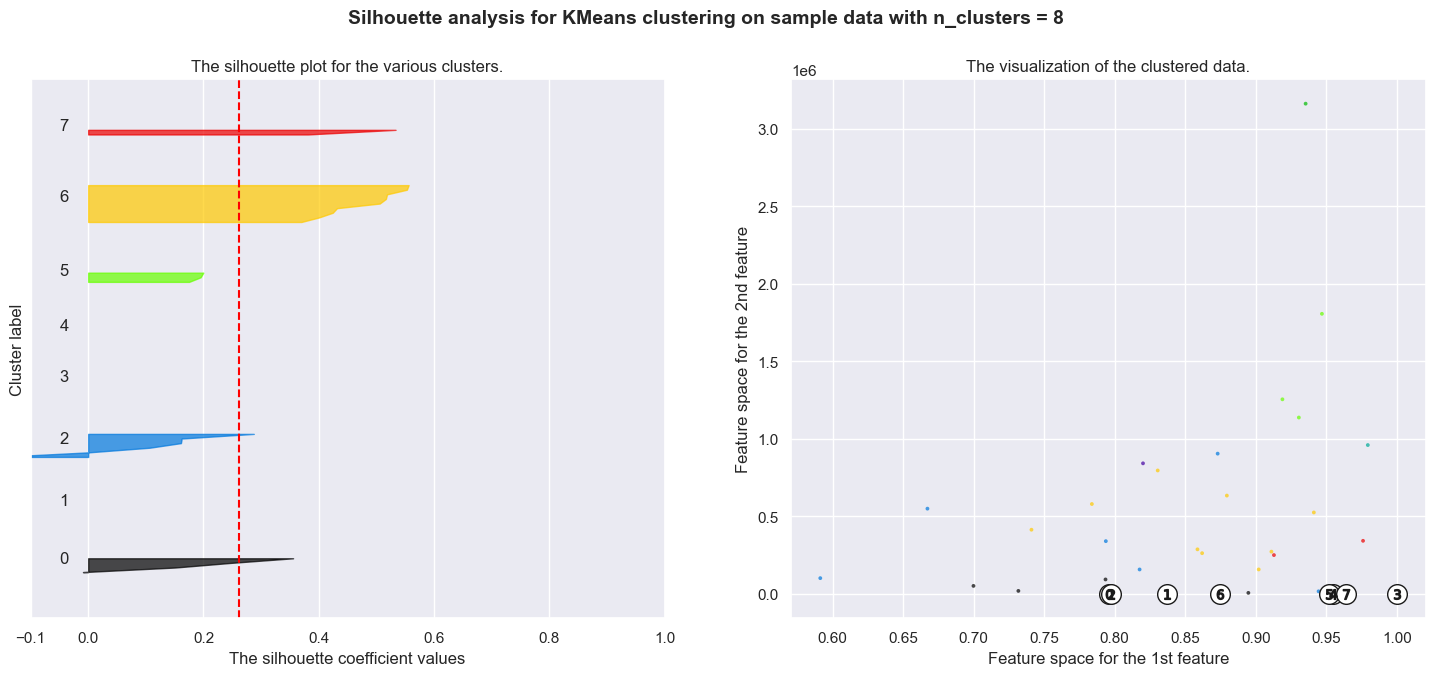

For n_clusters = 13 The average silhouette_score is : 0.21219537913800193


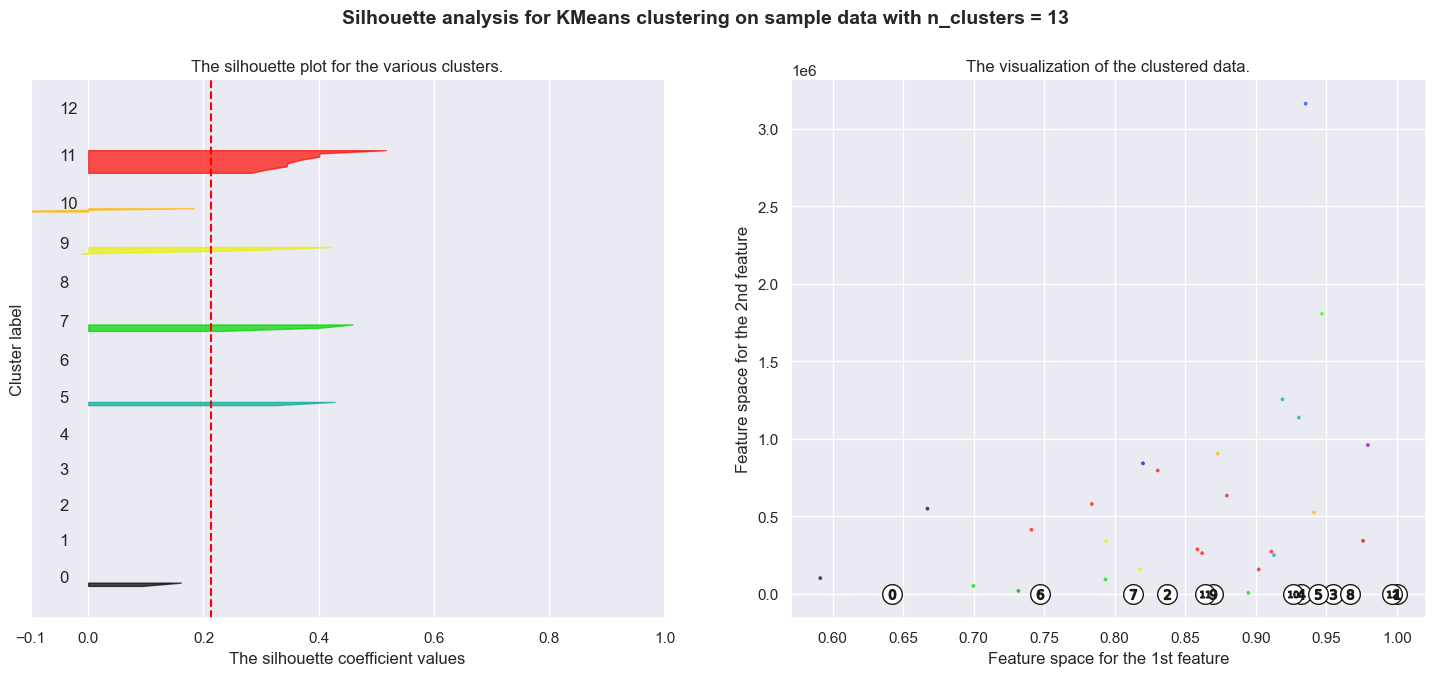

In [69]:

# Obter classificação com a quantidade de clusters sugerida pelos métodos seleção
sugestoes_clusters=[2,8,13]
for k in sugestoes_clusters:
    classificacao=avaliar_opcoes_arranjo(k,k,dados)
    imprimir_grafico_analise_arranjo(classificacao[0])

In [70]:
# definir o range de clusters que serão avaliados
QTD_MIN_CLUSTERS=3
QTD_MAX_CLUSTERS=7

# Gerar dados sintéticos para classificação
# X=pd.DataFrame( np.random.rand(10000, 9))


# Resultado da avaliação 
resultados_pre_otimizacao= avaliar_opcoes_arranjo(QTD_MIN_CLUSTERS,QTD_MAX_CLUSTERS,dados)
resultados_validos=obter_resultados_validos(resultados_pre_otimizacao)

resultados_validos

[]

For n_clusters = 3 The average silhouette_score is : 0.4221019947669364


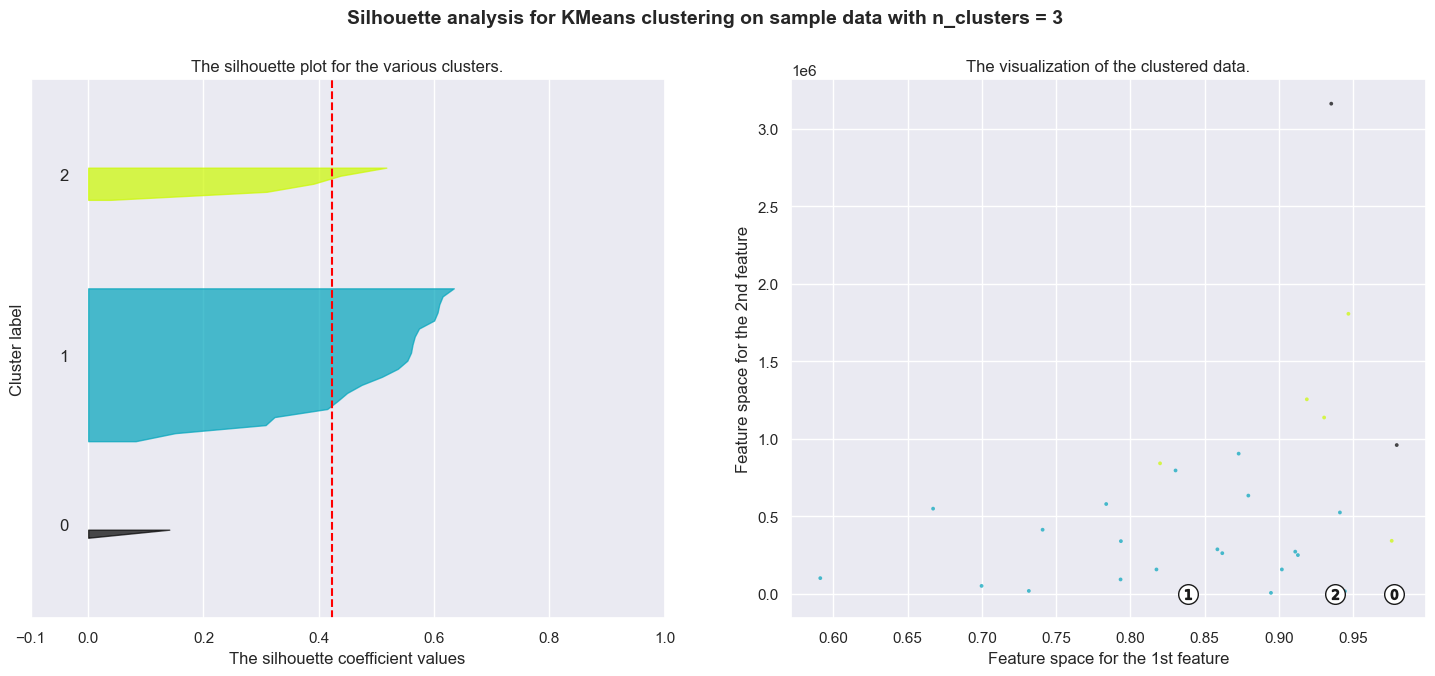

For n_clusters = 4 The average silhouette_score is : 0.2884864492668728


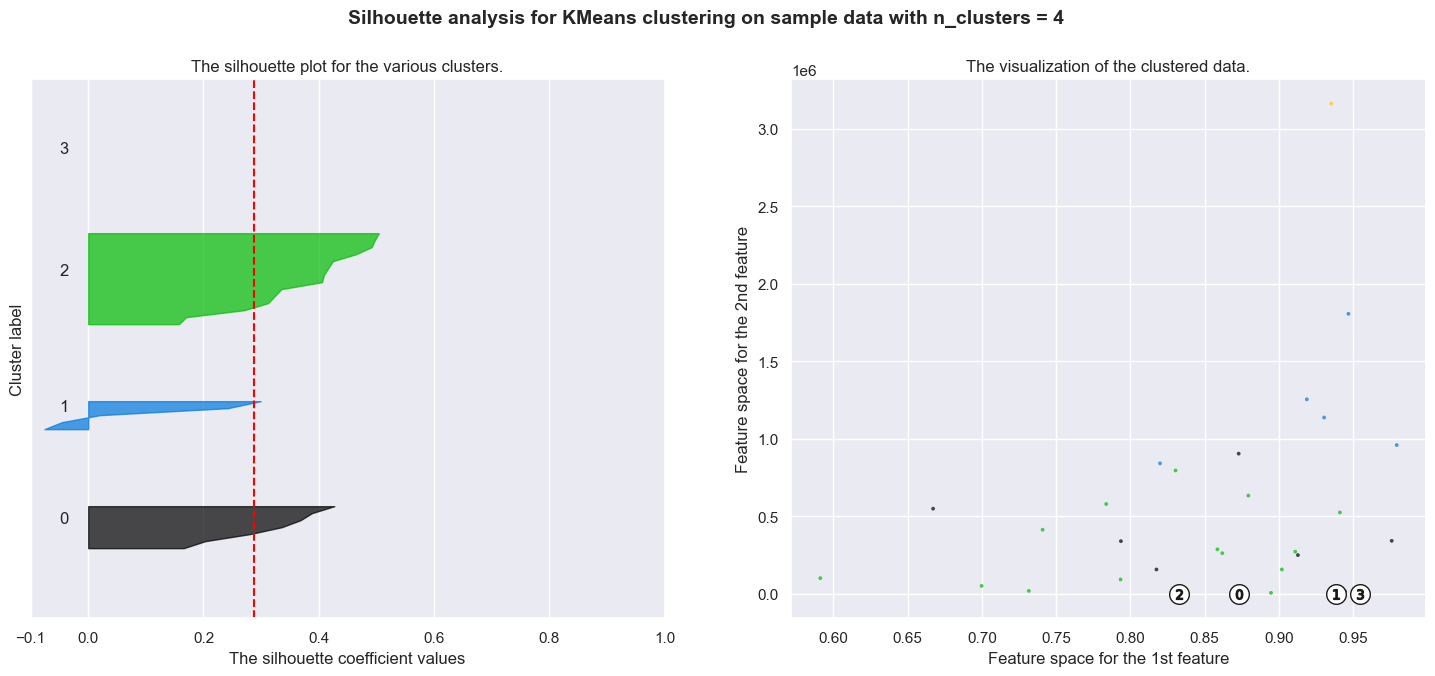

For n_clusters = 5 The average silhouette_score is : 0.29236230242785094


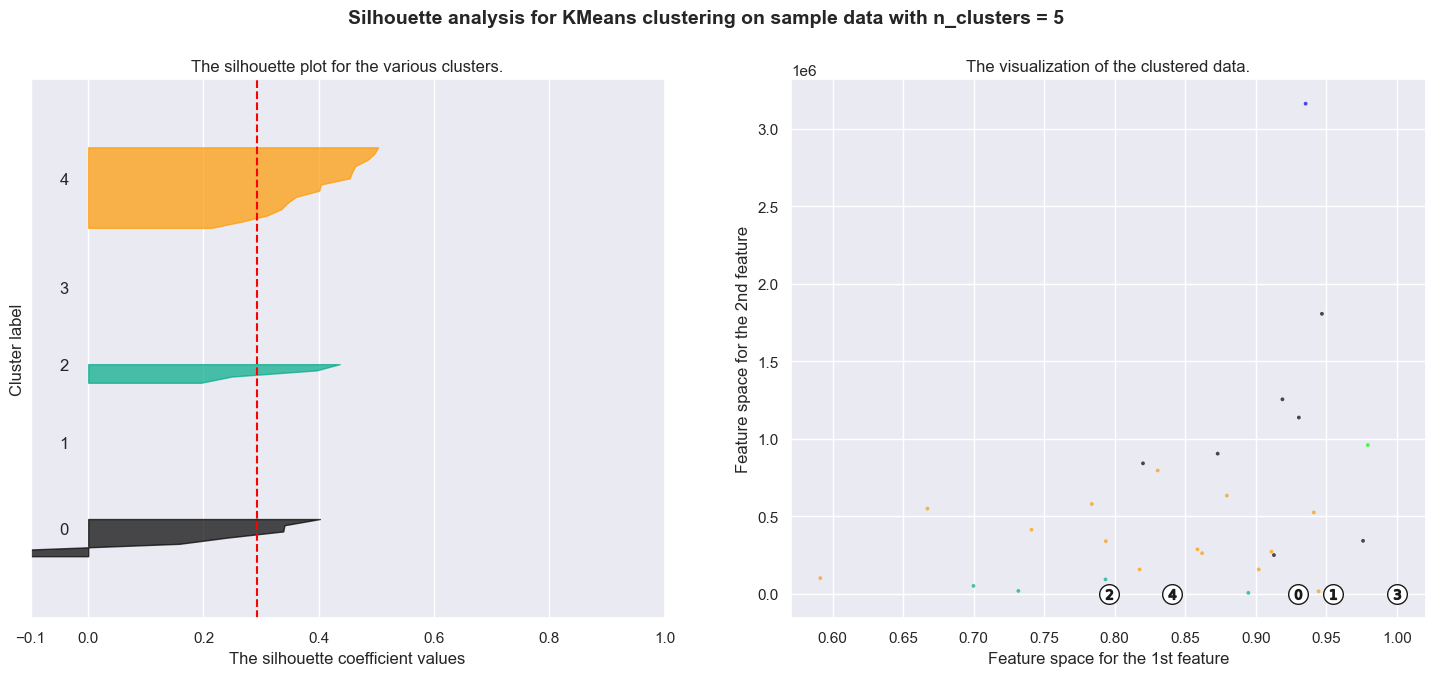

For n_clusters = 6 The average silhouette_score is : 0.3026918640545916


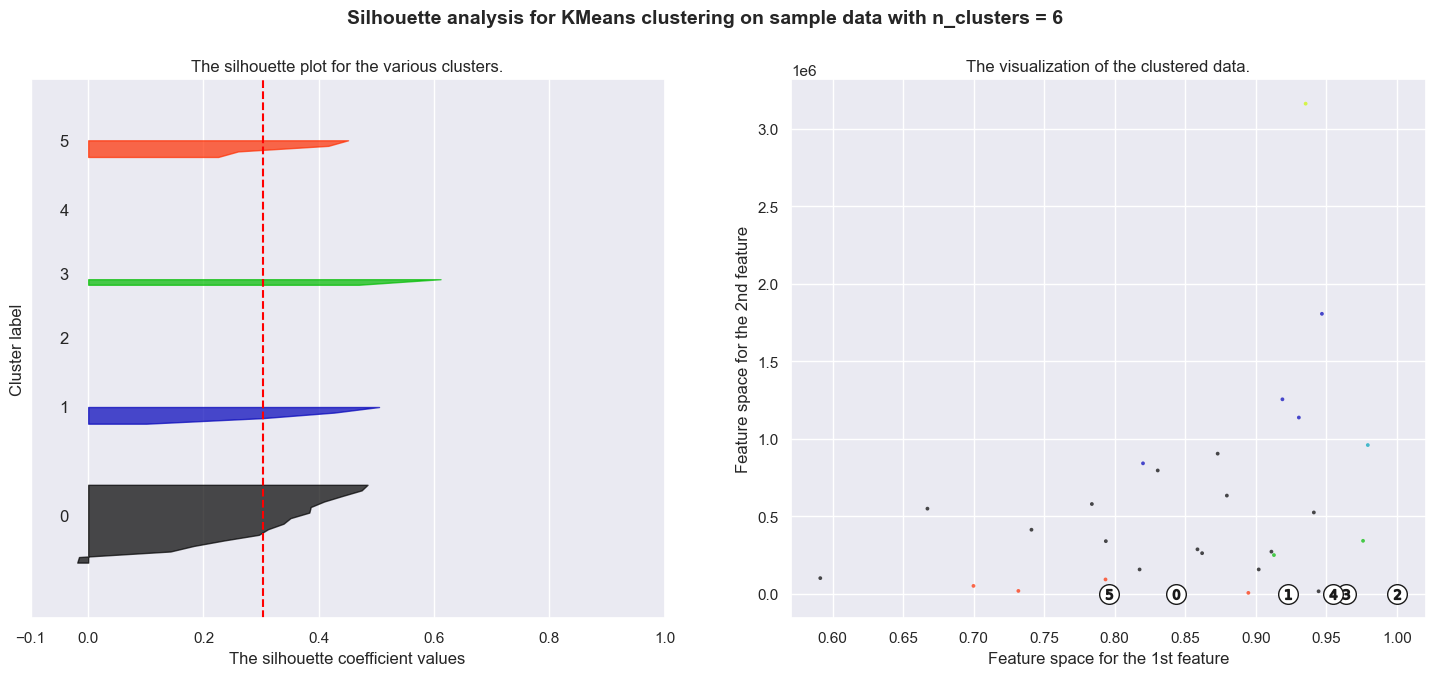

For n_clusters = 7 The average silhouette_score is : 0.28245775206015844


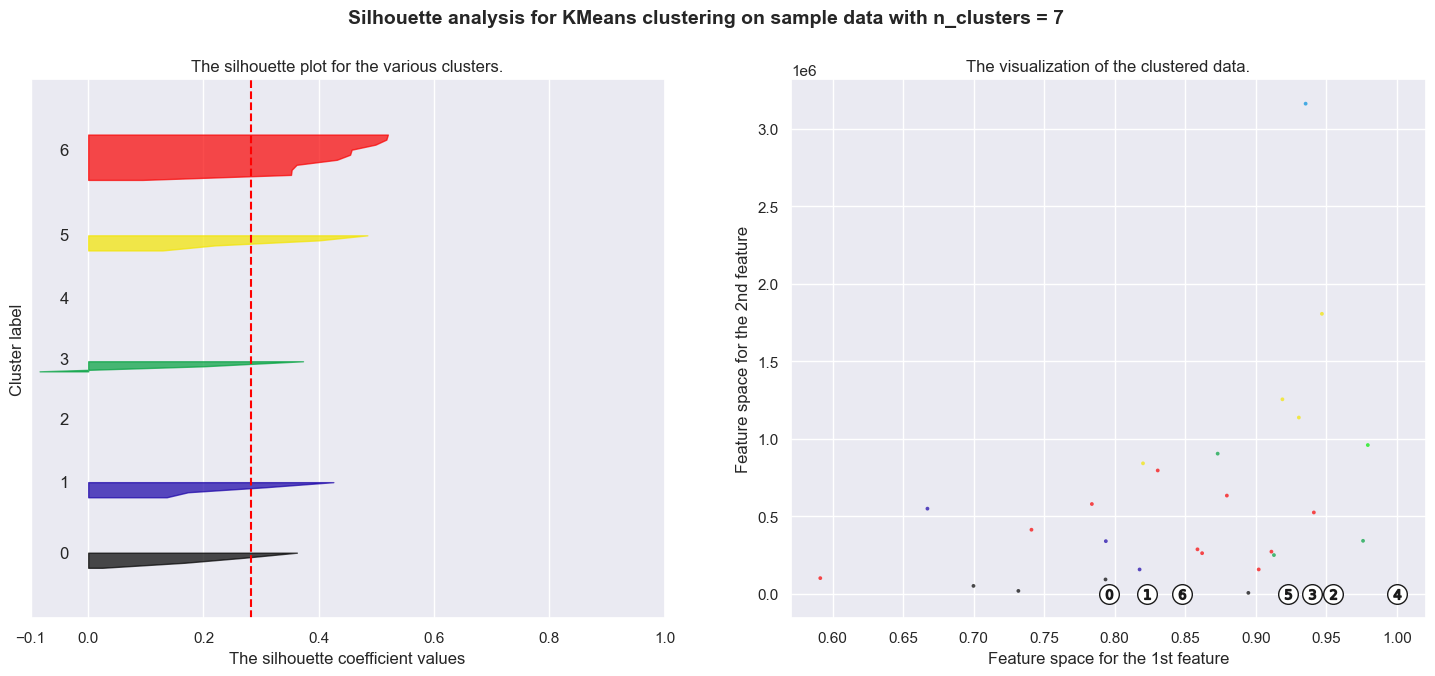

In [71]:
for arranjo in resultados_pre_otimizacao:
    imprimir_grafico_analise_arranjo(arranjo)
    

### Avaliação da Entropia das variáveis do dataset

<Axes: xlabel='entropia', ylabel='variavel'>

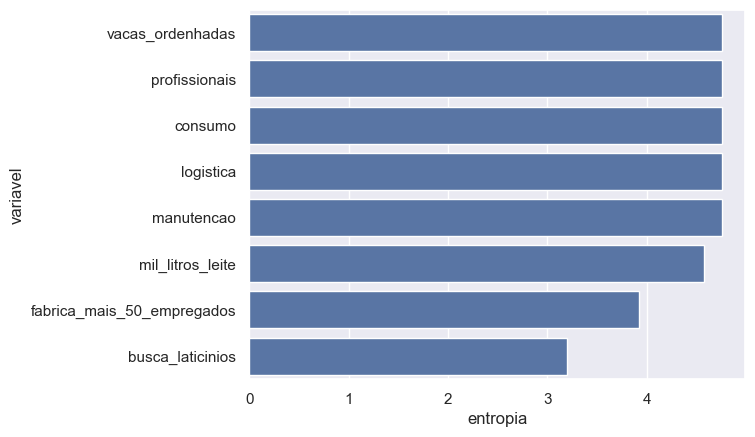

In [77]:

entropias = []

for col in range(dados.shape[1]):
    entropias.append({"variavel":dados.columns[col],"entropia":calcular_entropia(dados.iloc[:,col])})

dfEntropias = pd.DataFrame(entropias)
dfEntropias.sort_values(by=["entropia"],ascending=False,inplace=True)

sns.barplot(dfEntropias,y="variavel",x="entropia")


In [78]:
dfEntropias

,variavel,entropia
0,vacas_ordenhadas,4.754887
2,profissionais,4.754887
3,consumo,4.754887
4,logistica,4.754887
5,manutencao,4.754887
1,mil_litros_leite,4.578781
7,fabrica_mais_50_empregados,3.926572
6,busca_laticinios,3.200289


In [79]:

resultados_validos=[]

melhor_arranjo=selecionar_melhor_opcao_arranjo(resultados_validos)

i_entropia=0
iteracao=1

sumario_iteracoes=[]

while melhor_arranjo is None:
    qtd_variaveis=dados.shape[1]
    if qtd_variaveis < 3:
        print(f"{iteracao} - SEM RESULTADOS VÁLIDOS: Dataset após a exclusão das variáveis não encontrou um resultado.")
        break
        
    #print(f"{iteracao} - SEM RESULTADOS VÁLIDOS: Analisar a entropia das variáveis.")

    #ajustar o nome da variável
    menor_entropia=dfEntropias.iloc[i_entropia]
    
    #print(f"Excluir a variável '{menor_entropia['variavel']}' do dataset ")
    
    # Excluir varíavel com menor entropia
    dados=dados.drop([menor_entropia["variavel"]],axis=1)
    
    # Refazer o K-means utilizando o novo dataset sem a variável com a menor entropia
    resultados= avaliar_opcoes_arranjo(QTD_MIN_CLUSTERS,QTD_MAX_CLUSTERS,dados)
    resultados_validos=obter_resultados_validos(resultados)
    
    melhor_arranjo=selecionar_melhor_opcao_arranjo(resultados_validos)

    dados_iteracao = {"iteracao":iteracao,
     "resultados_validos":len(resultados_validos),
     "variavel_excluida":f'Variável: {menor_entropia["variavel"]} [{menor_entropia["entropia"]}]',}

    sumario_iteracoes.append(dados_iteracao)
    
    i_entropia+=1
    iteracao+=1
    
display(HTML(f'<h3> \o/ Melhor arranjo encontrado após {iteracao-1} iterações!</h3>'))

imprimir_dados_arranjo(melhor_arranjo)

For n_clusters = 3 The average silhouette_score is : 0.5952095006374358


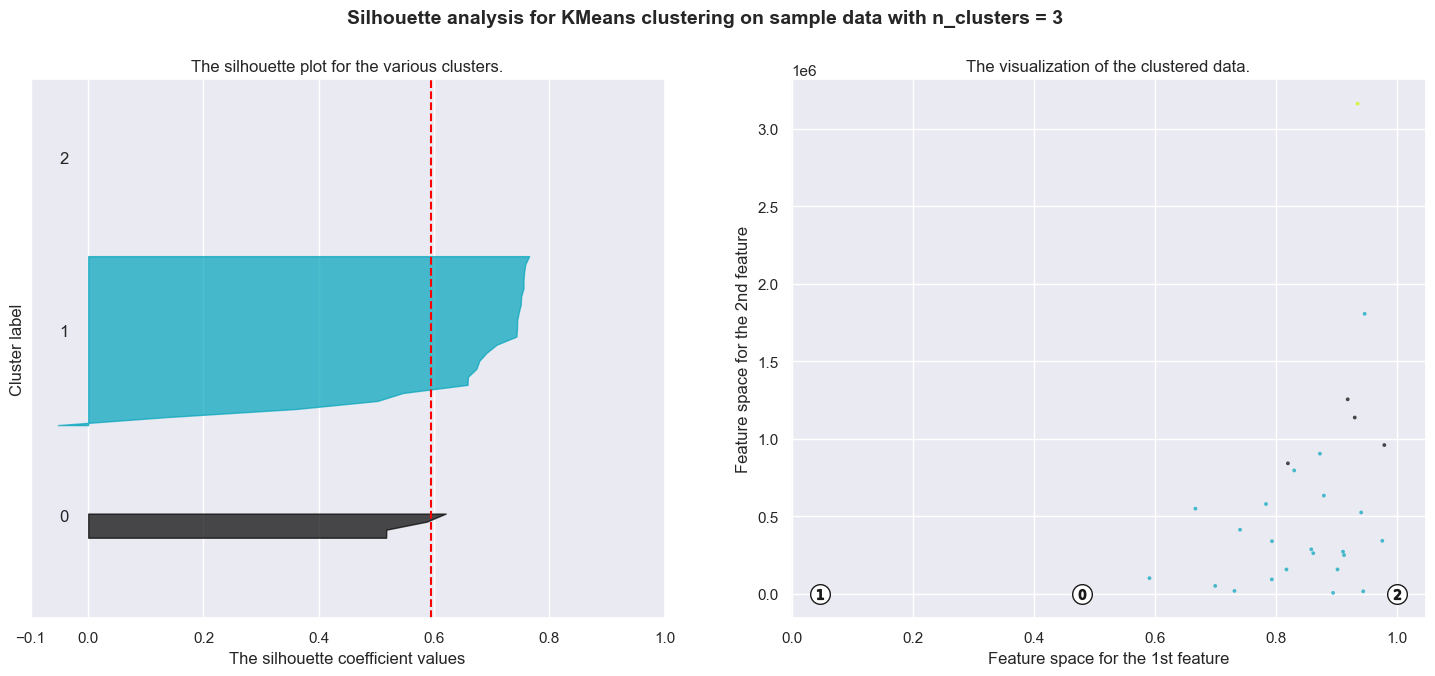

In [80]:
imprimir_grafico_analise_arranjo(melhor_arranjo)

In [81]:
# Ver detalhes das iterações da análise de entropia
pd.DataFrame(sumario_iteracoes)

,iteracao,resultados_validos,variavel_excluida
0,1,0,Variável: vacas_ordenhadas [4.754887498268193]
1,2,0,Variável: profissionais [4.754887498268193]
2,3,0,Variável: consumo [4.754887498268193]
3,4,0,Variável: logistica [4.754887498268193]
4,5,2,Variável: manutencao [4.754887498268193]


In [82]:
# Variáveis restantes após otimização
dados

,mil_litros_leite,busca_laticinios,fabrica_mais_50_empregados
0,0.001780,0.00,0.009804
1,0.012105,0.25,0.039216
2,0.000000,0.00,0.000000
3,0.001409,0.12,0.058824
4,0.094944,0.37,0.127451
5,0.053606,0.18,0.088235
6,0.000000,0.25,0.000000
7,0.036600,0.56,0.098039
8,0.361753,0.25,0.186275
9,0.009008,0.18,0.019608


In [83]:
# Ver os resultados válidos ao final das análises
[imprimir_dados_arranjo(r) for r in resultados_validos]

[None, None]

In [84]:
[imprimir_dados_arranjo(r) for r in resultados]

[None, None, None, None, None]

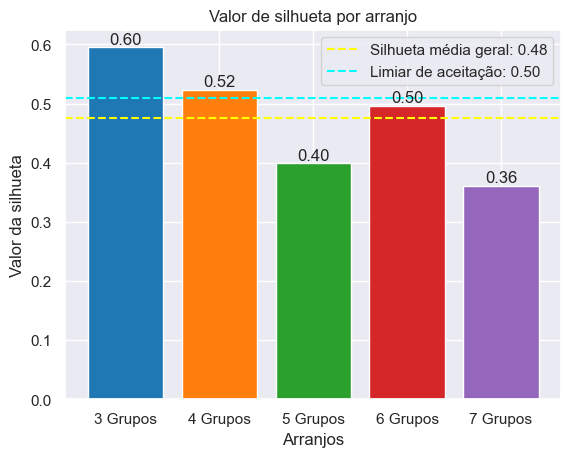

In [85]:

silhuetas=[r["silhueta_media"]for r in resultados]
nomes_arranjo=[r["arranjo"]for r in resultados]

silhueta_media_geral = np.mean(silhuetas)

cores = [a[0] for a in mcolors.TABLEAU_COLORS.items()][:len(nomes_arranjo)]

fig, ax = plt.subplots()
bar_container = ax.bar(nomes_arranjo, silhuetas,color=cores)

# Adicionar uma linha para indicar a média geral da silhueta
ax.axhline(y=silhueta_media_geral, color='yellow', linestyle='--', label=f'Silhueta média geral: {silhueta_media_geral:.2f}')

# Adicionar uma linha para indicar a média geral da silhueta
ax.axhline(y=0.51, color='cyan', linestyle='--', label=f'Limiar de aceitação: {0.50:.2f}')

# Adicionar legenda para as linhas
ax.legend()

ax.set(ylabel='Valor da silhueta', title='Valor de silhueta por arranjo',xlabel="Arranjos")
ax.bar_label(bar_container, fmt='{:,.2f}')

plt.show()

### Salvar arquivo com resultado da classificação

In [86]:
dfClassificacao=dfArquivo[["estado"]]

dfArquivo["Grupo"]=pd.Series(melhor_arranjo["rotulos"])

dfArquivo.to_csv("dataset_classificado.csv",sep=";")

In [87]:
dados=zip(melhor_arranjo['rotulos'],melhor_arranjo['silhuetas'])

df=pd.DataFrame(dados)

df

,0,1
0,1,0.658695
1,1,0.755050
2,1,0.658008
3,1,0.746832
4,1,0.546360
5,1,0.742737
6,1,0.743882
7,1,0.360128
8,1,-0.052578
9,1,0.764909


14 24
46 56
57 67


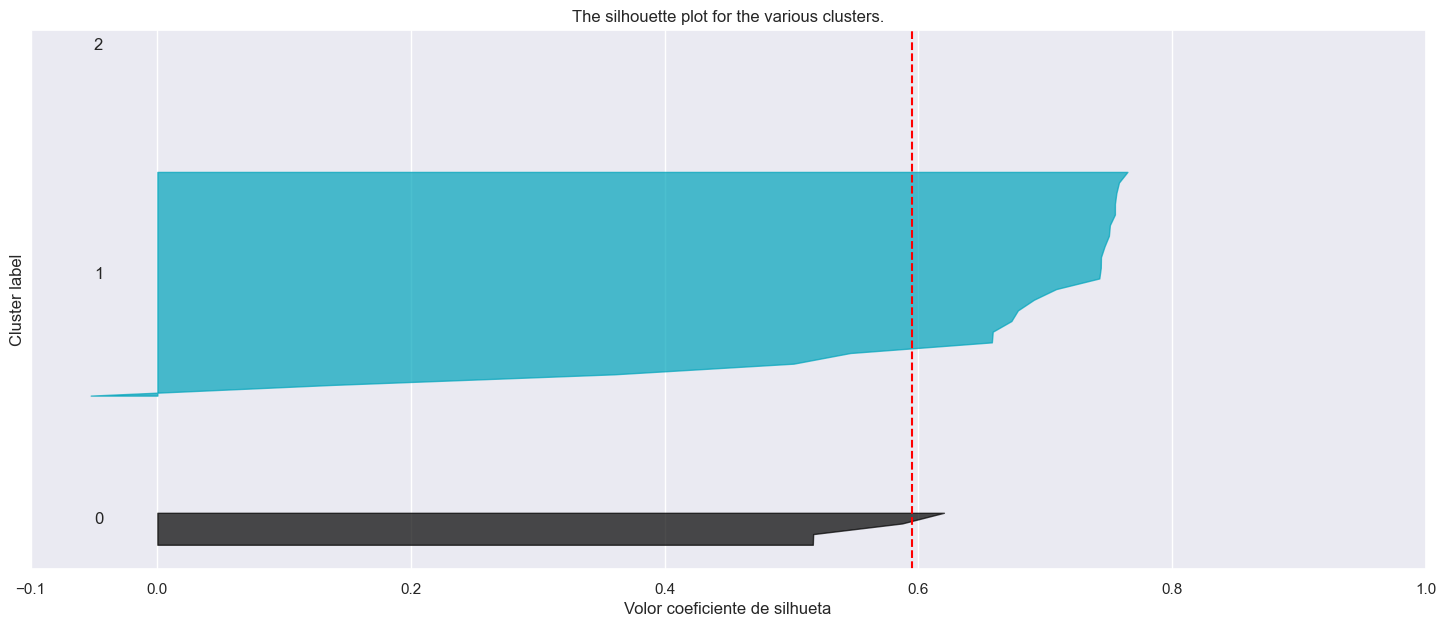

In [88]:
y_lower = 10
cluster=melhor_arranjo 
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 7)

for i in range(cluster["qtd_grupos"]):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = cluster["silhuetas"][cluster["rotulos"] == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / cluster["qtd_grupos"])
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    print(y_upper,y_lower)
    
    
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("Volor coeficiente de silhueta")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=cluster["silhueta_media"], color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])



In [89]:
df = pd.DataFrame(zip(cluster["silhuetas"],cluster["rotulos"]),columns=["silhuetas","rotulos"])
df.sort_values(by=["rotulos","silhuetas"],inplace=True)
rotulos = list(df.groupby(["rotulos"]).count().index)
rotulos
melhor_arranjo["silhueta_media"]

0.5952095006374358

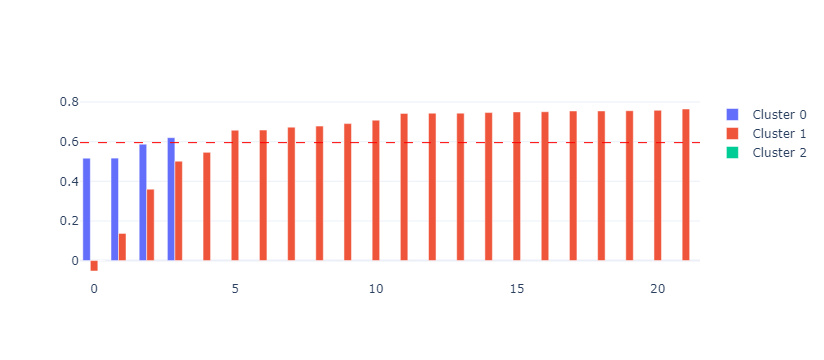

In [90]:

pio.templates.default = "plotly_white"

# fig = px.bar(df.sort_values(by=["rotulos"]), y=df.columns[0], color=df.columns[1])
# fig.show()

data=[]
for r in rotulos:
    data.append(
        go.Bar(name=f"Cluster {r}",  y=df["silhuetas"][df["rotulos"]==r])
    )

fig = go.Figure(data=data)
fig.add_hline(y=cluster["silhueta_media"], 
                  line_width=1, 
                  line_dash="dash", 
                  line_color="red")
# Change the bar mode
fig.update_layout(barmode='group')
fig

In [91]:
rotulos

[0, 1, 2]

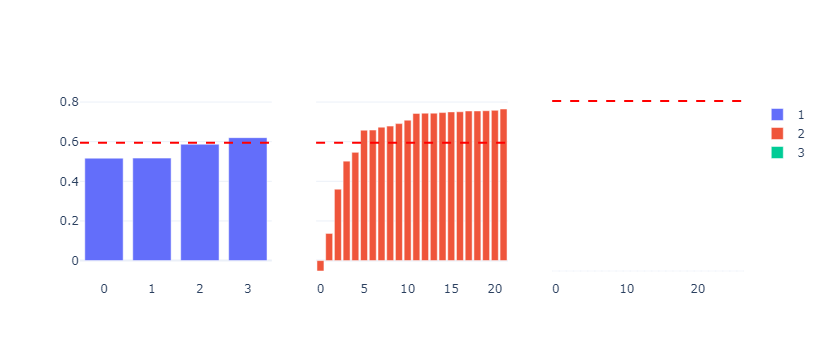

In [92]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly import data

rows,cols = df.shape

fig = make_subplots(rows=1, cols=len(rotulos), shared_yaxes=True)

fig.add_trace(
    go.Bar(y=df["silhuetas"][df["rotulos"]==0], name="1"), 1, 1
)
fig.add_trace(
    go.Bar(y=df["silhuetas"][df["rotulos"]==1], name="2"),
    1,
    2,
)

fig.add_trace(
    go.Bar(y=df["silhuetas"][df["rotulos"]]==2, name="3"),
    1,
    3,
)

fig.add_hline(y=cluster["silhueta_media"],
                  line_width=2,
                  line_dash="dash",
                  line_color="red")

fig.show()

In [93]:
df_1=df.groupby("rotulos",as_index=False).count()
df_1

,rotulos,silhuetas
0,0,4
1,1,22
2,2,1


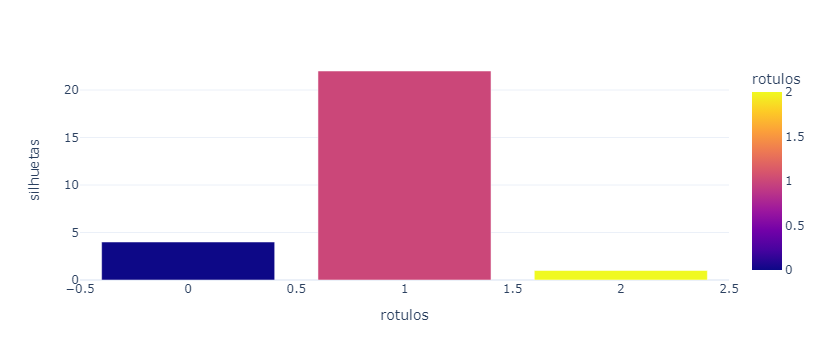

In [95]:
df=df.groupby("rotulos").count()
fig = px.bar(df_1, y="silhuetas",x="rotulos", color="rotulos")
fig

In [96]:
 resumo = pd.DataFrame(cluster["resumo_classificacao"])         
 resumo["nome_grupo"] = "G"+(resumo["grupo"]).astype(str)      
 resumo["nome_grupo"]

0    G1
1    G2
2    G3
Name: nome_grupo, dtype: object

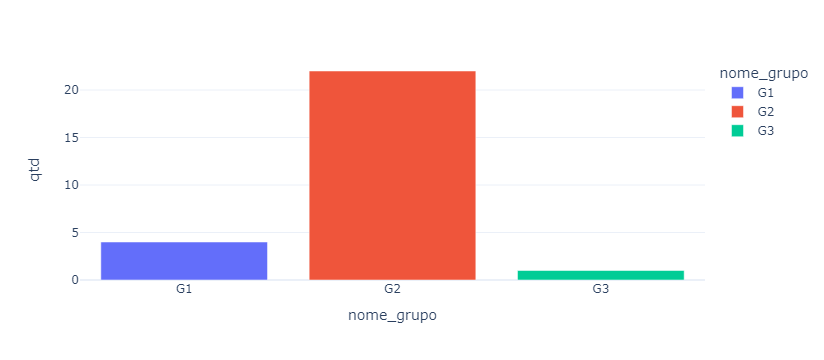

In [97]:
fig = px.bar(resumo, x="nome_grupo", y="qtd", color="nome_grupo")  
fig

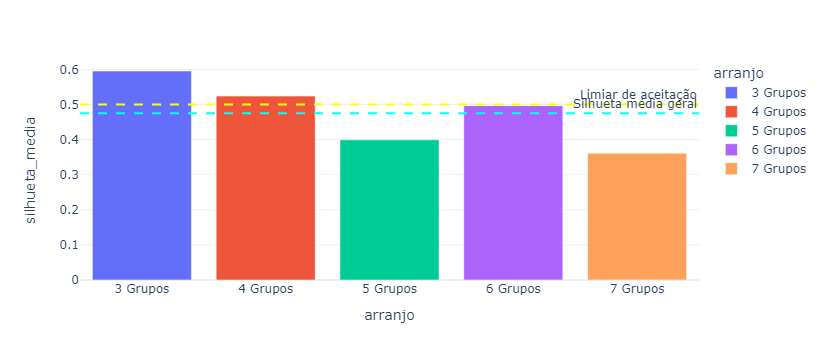

In [98]:
silhuetas=[r["silhueta_media"]for r in resultados]
nomes_arranjo=[r["arranjo"]for r in resultados]

df=pd.DataFrame({'arranjo':nomes_arranjo,'silhueta_media':silhuetas})


fig = px.bar(df, x="arranjo", y="silhueta_media", color="arranjo")  

fig.add_hline(y=df["silhueta_media"].mean(),
              line_width=2,          
              line_dash="dash",      
              line_color="cyan",
              annotation_text="Silhueta média geral") 

fig.add_hline(y=0.5,
              line_width=2,          
              line_dash="dash",      
              line_color="yellow",
              annotation_text="Limiar de aceitação")   

fig



In [99]:
arranjos=[]

for r in resultados:
    arranjos.append(r["arranjo"])

melhor_arranjo

{'arranjo': '3 Grupos',
 'qtd_grupos': 3,
 'silhueta_media': 0.5952095006374358,
 'resumo_classificacao': [{'grupo': 1,
   'qtd': 4,
   'silhueta': 0.5603527630344277,
   'centroides': array([0.48027383, 0.495     , 0.39215686])},
  {'grupo': 2,
   'qtd': 22,
   'silhueta': 0.6286020665942298,
   'centroides': array([0.04685184, 0.24090909, 0.06194296])},
  {'grupo': 3, 'qtd': 1, 'silhueta': 0.0, 'centroides': array([1., 1., 1.])}],
 'rotulos': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        1, 0, 0, 1, 1]),
 'silhuetas': array([ 0.65869518,  0.75505041,  0.65800754,  0.74683244,  0.54635956,
         0.74273699,  0.74388153,  0.36012825, -0.05257845,  0.76490894,
         0.69115264,  0.75822435,  0.        ,  0.74404745,  0.75105159,
         0.6202175 ,  0.67339704,  0.75029843,  0.13699396,  0.75503746,
         0.58724975,  0.67853836,  0.50165542,  0.51710828,  0.51683552,
         0.75616313,  0.70866325]),
 'centroides': array([[0.48027383, 0.49